In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform, loguniform
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, precision_recall_curve)

In [2]:
X_train = pd.read_csv(r'dataset_fix\X_train.csv')
X_test = pd.read_csv(r'dataset_fix\X_test.csv')
y_train = pd.read_csv(r'dataset_fix\y_train.csv')
y_test = pd.read_csv(r'dataset_fix\y_test.csv')

In [3]:
# 0) Hitung rasio imbalance utk acuan scale_pos_weight
pos = np.sum(y_train)
neg = len(y_train) - pos
spw_base = neg / pos  # aturan praktis XGBoost

c:\Users\Agung\Documents\Stage_3_Part1\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [4]:
# 1) Estimator dasar (param lain dicari lewat random search)
xgb = XGBClassifier(
    random_state=42,
    tree_method="hist",     # cepat & efisien
    eval_metric="logloss",  # metrik internal
    n_jobs=-1
)

In [5]:
# =====================================
# Ruang pencarian hyperparameter (versi replika dari kode pertama)
# =====================================

param_dist = {
    "n_estimators": np.arange(200, 801, 100),     # [200, 300, 400, 500, 600, 700, 800]
    "learning_rate": np.linspace(0.01, 0.3, 10),  # 0.01, 0.04, ..., 0.28, 0.3
    "max_depth": [2, 3, 4, 5, 6],                 # kedalaman pohon
    "min_child_weight": [1, 2, 5],                # kontrol leaf minimum
    "subsample": [0.6, 0.8, 1.0],                 # sampling baris
    "colsample_bytree": [0.6, 0.8, 1.0],          # sampling kolom
    "gamma": [0, 0.5, 1, 2]                       # penalti split
    # Catatan: reg_alpha, reg_lambda, scale_pos_weight sengaja dihapus 
    # agar persis dengan kode referensi pertama
}


In [6]:
# 3) CV stratified + multi-metric (refit = recall)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "recall": "recall",
    "precision": "precision",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "accuracy": "accuracy"
}

In [7]:

rs_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring="f1",
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


In [8]:
# 4) Jalankan pencarian
rs_xgb.fit(X_train, y_train)

print("="*60)
print("=== Hasil RandomizedSearchCV (XGBoost) ===")
print("Best Params :", rs_xgb.best_params_)
print("Best CV F1  :", rs_xgb.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
=== Hasil RandomizedSearchCV (XGBoost) ===
Best Params : {'subsample': 0.8, 'n_estimators': np.int64(500), 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': np.float64(0.10666666666666666), 'gamma': 2, 'colsample_bytree': 1.0}
Best CV F1  : 0.8681371647243417


In [9]:
# 5) Evaluasi di test set (threshold default)
best_xgb = rs_xgb.best_estimator_
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred, target_names=["No Churn","Churn"]))
print(f"ROC-AUC (Test): {roc_auc_score(y_test, y_proba):.4f}")


Confusion Matrix (Test):
[[205  10]
 [  8  77]]

Classification Report (Test):
              precision    recall  f1-score   support

    No Churn       0.96      0.95      0.96       215
       Churn       0.89      0.91      0.90        85

    accuracy                           0.94       300
   macro avg       0.92      0.93      0.93       300
weighted avg       0.94      0.94      0.94       300

ROC-AUC (Test): 0.9317


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["0", "1"],
            yticklabels=["0", "1"])

plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

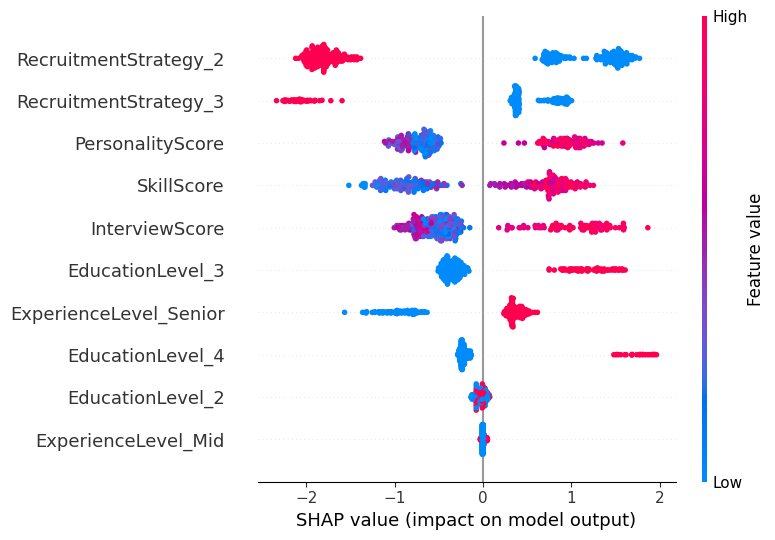

In [15]:
# Import library shap
import shap

# Hitung SHAP values menggunakan TreeExplainer karena model XGBoost
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)

In [16]:
# Simpan model XGBoost terbaik menggunakan joblib
import joblib
joblib.dump(best_xgb, 'model_BestXG.pkl')


['model_BestXG.pkl']